# Splice site prediction on C. Elegans DNA
In this notebook we explore different approaches to predict Splice sites on a C. Elegans DNA dataset. 

## Setup

### Import packages

In [37]:
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
import re
import glob

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, average_precision_score, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from imblearn.ensemble import BalancedRandomForestClassifier, RUSBoostClassifier, EasyEnsembleClassifier

from squiggle import transform

import tensorflow.keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, clone_model, Model

import shogun as sg

### Load dataset

Encode the dna string as a list of floats

In [3]:
dna_float_encoding_dict = { 'A': 0.25, 'C': 0.5,  'G': 0.75, 'T': 1.0 }
dna_float_decoding_dict = { '0.25': 'A', '0.5': 'C',  '0.75': 'G', '1.0': 'T' }

def encode_dna_string_to_floats(dna_string):
    float_encoded_dna = []
    
    for n in dna_string:
        float_encoded_dna.append(dna_float_encoding_dict[n])
    
    return np.array(float_encoded_dna)

def decode_dna_string_from_floats(dna_np):
    dna_string = ''
    
    for n in dna_np:
        dna_string = dna_string + dna_float_decoding_dict['{0}'.format(n)]
    
    return dna_string

We split the data into a training (80%) and a test set. No model is evaluated on the test split until the final evaluation. 

In [4]:
df = pd.read_csv('data/C_elegans_acc_seq.csv', names=['labels', 'sequences'])

labels_df = df['labels']
dna_sequences = np.array(df['sequences'])

encoded_dna_sequences = np.array([encode_dna_string_to_floats(c) for c in dna_sequences])
binary_labels = np.array([0 if x == -1 else 1 for x in np.array(labels_df)])

x_train, x_test, y_train, y_test = train_test_split(encoded_dna_sequences, np.array(labels_df), test_size=0.2, random_state=29)

### Dataset analysis

In [5]:
labels = np.array(labels_df)
fraction_of_class1_samples = np.array(labels[labels==1]).shape[0] / labels.shape[0]
print("Class 1 (spline site) contains {0}% of the data samples.".format(round(fraction_of_class1_samples, 2) * 100))
print("For each sample of class 1 there are {0} samples of class -1".format(1/fraction_of_class1_samples))

number_of_features = x_train.shape[1]
print("Each sample consists of {0} features, i.e. nucleotides".format(number_of_features))

Class 1 (spline site) contains 9.0% of the data samples.
For each sample of class 1 there are 11.0 samples of class -1
Each sample consists of 82 features, i.e. nucleotides


The C. Elegans data set is highly unbalanced. the non-spline sites make more than 90% of the data set. 

### Class weights
One major approach for data imbalance is to use class weights. We are using a common formula to calculate good weights that we then used in all models. 

In [6]:
weight_for_0 = (1 / y_train[y_train == -1].shape[0])*x_train.shape[0]/2.0
weight_for_1 = (1 / y_train[y_train == 1].shape[0])*x_train.shape[0]/2.0

class_weight = {-1: weight_for_0, 1: weight_for_1}
class_weight_01 = {0: weight_for_0, 1: weight_for_1}

print('Weight for class -1: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class -1: 0.55
Weight for class 1: 5.71


### Helper functions

In [82]:
test_result_file = 'elegans_results_test.csv'
with open(test_result_file, 'w', newline='\n') as file:
    writer = csv.writer(file, delimiter=';')
    writer.writerow(["model_name", "AUROC", "AUPRC"])

Takes a model wrapper and evaluates its performance on the provided evaluation set, outputs the OP, PC and IoU and saves the results in a csv file if required.

In [87]:
def evaluate_model(model_wrapper, X, Y_true, verbose=False, model_name=None):
    Y_pred = model_wrapper.predict(X)
    
    f1 = f1_score(Y_true, Y_pred, average="macro")
    acc = accuracy_score(Y_true, Y_pred)
    auroc = roc_auc_score(Y_true, Y_pred)
    auprc = average_precision_score(Y_true, Y_pred)
    cm = confusion_matrix(Y_true, Y_pred)
    acc_per_class = cm.diagonal() / np.sum(cm, axis=1)
    
    if verbose:
        print("\n=================================================================")
        print("\nAccuracy:", round(acc, 5))
        print("F1:      ", round(f1, 5))
        print("AUROC    ", round(auroc, 5))
        print("AUPRC    ", round(auprc, 5))
        print("Confusion matrix:")
        print(cm)
        print("Accuracy per class")
        print(acc_per_class)
        print("\n=================================================================\n")
        
    if not model_name == None:
        with open(test_result_file, 'a', newline='\n') as f:
            writer = csv.writer(f, delimiter=';')
            writer.writerow([model_name, round(auprc, 5), round(auprc, 5)])
            
    return (f1, acc, acc_per_class, auroc, auprc)

Runs K-Fold cross-validation and pretty-prints intermediate results.

In [8]:
def cross_validation(model_wrapper, X, Y, folds=10, message=''):
    kf = KFold(n_splits=folds, shuffle=True)
    i = 0.
    f1_a = 0
    acc_a = 0
    acc_per_class_a = 0
    auroc_a = 0
    auprc_a = 0
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        model_wrapper.fit(X_train, Y_train)
        f1, acc, acc_per_class, auroc, auprc = evaluate_model(model_wrapper, X_test, Y_test)
        f1_a += f1
        acc_a += acc
        acc_per_class_a += acc_per_class
        auroc_a += auroc
        auprc_a += auprc
        i += 1
    print("\n=================================================================")
    if message != '':
        print(message)
    print("\nAverage Accuracy:", round(acc_a/i, 5))
    print("Average F1:      ", round(f1_a/i, 5))
    print("Average AUPRC:      ", round(auprc_a/i, 5))
    print("Average AUROC:      ", round(auroc_a/i, 5))
    print("Average Accuracy per class")
    print(acc_per_class_a / i)
    print("\n=================================================================\n")

In [32]:
def plot_pr_curve(model_wrapper, X, Y):
    p, r, t = precision_recall_curve(Y, model_wrapper.predict(X))
    apc = average_precision_score(Y, model_wrapper.predict(X))
    disp = plt.plot(r, p)
    plt.title('2-class Precision-Recall curve: '
                    'AP={0:0.2f}'.format(apc))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()

In [33]:
def plot_roc_curve(model_wrapper, X, Y):
    fpr, tpr, t = roc_curve(Y, model_wrapper.predict(X))
    ras = roc_auc_score(Y, model_wrapper.predict(X))
    plt.plot(fpr, tpr)
    plt.title('2-class Receiver operating characteristic curve: '
                    'ROC_AUC score={0:0.2f}'.format(ras))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

In [9]:
class Sklearn_Model_Wrapper():
    def __init__(self, model):
        self.model = model
    
    def fit(self, X, Y):
        self.model.fit(X, Y)
    
    def predict(self, X):
        return self.model.predict(X)

In [10]:
class Shogun_Model_Wrapper():
    def __init__(self):
        pass
    
    def fit(self, X, Y):
        features_train = sg.StringCharFeatures([decode_dna_string_from_floats(c) for c in X], sg.DNA)
        labels_train = sg.BinaryLabels(Y)

        C = 1.0
        epsilon = 0.001
        gauss_kernel = sg.WeightedDegreeStringKernel(features_train, features_train, 15)

        svm = sg.LibSVM(C, gauss_kernel, labels_train)
        svm.set_epsilon(epsilon)
        svm.train()
        self.model = svm
    
    def predict(self, X):
        features_test = sg.StringCharFeatures([decode_dna_string_from_floats(c) for c in X], sg.DNA)        
        return self.model.apply(features_test).get_labels()

In [11]:
class Keras_Model_Wrapper():
    def __init__(self, model, batch_size=64, epochs=10, loss='categorical_crossentropy', class_weights={0:1, 1:1}):
        self.model = model
        self.epochs = epochs
        self.batch_size = batch_size
        self.loss = loss
        self.class_weights = class_weights
    
    def fit(self, X, Y):
        ohe = OneHotEncoder()
        one_hot_encoded_y = ohe.fit_transform(Y.reshape(-1, 1)).toarray()
        model = clone_model(self.model)
        model.compile(loss=self.loss, optimizer='adam', metrics=['accuracy'])
        model.fit(X, one_hot_encoded_y, class_weight=self.class_weights, 
                       batch_size=self.batch_size, epochs=self.epochs, verbose=0)
        self.trained_model = model
    
    def predict(self, X):
        probas = self.trained_model.predict(X)
        predictions = np.argmax(probas, axis=1)
        return np.array([-1 if x == 0 else 1 for x in predictions])

In [12]:
class LSTM_Model_Wrapper():
    def __init__(self, model, batch_size=64, epochs=10, loss='categorical_crossentropy', class_weights={0:1, 1:1}):
        self.model = model
        self.epochs = epochs
        self.batch_size = batch_size
        self.loss = loss
        self.class_weights = class_weights
    
    def fit(self, X, Y):
        Y = ((Y+1)/2.).astype(int)
        
        model = clone_model(self.model)
        model.compile(loss=self.loss, optimizer='adam', metrics=['accuracy'])
        model.fit(X, Y, class_weight=self.class_weights, 
                       batch_size=self.batch_size, epochs=self.epochs, verbose=0)
        self.trained_model = model
    
    def predict(self, X):
        probas = self.trained_model.predict(X)
        predictions = np.argmax(probas, axis=1)
        return np.array([-1 if x == 0 else 1 for x in predictions])

## Models
In this section we experiment with different models and parameters. All models are evaluated using cross validation on the training set. We used the averaged scores over all folds to get a good approximation of how the model performs on new/unseen data. 

### SVM

In [12]:
svm = Sklearn_Model_Wrapper(LinearSVC(random_state=0, tol=1e-5, max_iter=2000))

cross_validation(svm, x_train, y_train)



Average Accuracy: 0.91705
Average F1:       0.67428
Average AUPRC:       0.23996
Average AUROC:       0.64759
Average Accuracy per class
[0.9757285 0.3194498]




In [269]:
svm = Sklearn_Model_Wrapper(LinearSVC(random_state=0, tol=1e-5, max_iter=5000, class_weight=class_weight))

cross_validation(svm, x_train, y_train)

C:\Users\m_lev\Anaconda3\envs\ml4hc-p4\lib\site-packages\sklearn\svm\_base.py:975: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\m_lev\Anaconda3\envs\ml4hc-p4\lib\site-packages\sklearn\svm\_base.py:975: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\m_lev\Anaconda3\envs\ml4hc-p4\lib\site-packages\sklearn\svm\_base.py:975: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\m_lev\Anaconda3\envs\ml4hc-p4\lib\site-packages\sklearn\svm\_base.py:975: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\m_lev\Anaconda3\envs\ml4hc-p4\lib\site-packages\sklearn\svm\_base.py:975: ConvergenceWarning: Liblinear failed to c



Average Accuracy: 0.8267
Average F1:       0.66958
Average AUPRC:       0.26376
Average AUROC:       0.81072
Average Accuracy per class
[0.83058832 0.79084967]




C:\Users\m_lev\Anaconda3\envs\ml4hc-p4\lib\site-packages\sklearn\svm\_base.py:975: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [270]:
svm = Sklearn_Model_Wrapper(LinearSVC(random_state=0, tol=1e-5, max_iter=10000, class_weight=class_weight))

cross_validation(svm, x_train, y_train)



Average Accuracy: 0.82557
Average F1:       0.66818
Average AUPRC:       0.26587
Average AUROC:       0.80767
Average Accuracy per class
[0.82942603 0.78590461]




In [271]:
svm = Sklearn_Model_Wrapper(SVC(random_state=0, tol=1e-5, max_iter=10000, class_weight=class_weight, kernel='poly'))

cross_validation(svm, x_train, y_train)



Average Accuracy: 0.91648
Average F1:       0.68577
Average AUPRC:       0.26437
Average AUROC:       0.6623
Average Accuracy per class
[0.97076253 0.35382852]




### Random Forest

In [22]:
random_forest = Sklearn_Model_Wrapper(RandomForestClassifier(max_depth=2, random_state=0))

cross_validation(random_forest, x_train, y_train)



Average Accuracy: 0.9125
Average F1:       0.4771
Average AUPRC:       0.0875
Average AUROC:       0.5
Average Accuracy per class
[1. 0.]




In [325]:
random_forest = Sklearn_Model_Wrapper(RandomForestClassifier(max_depth=80, random_state=0, bootstrap=True))

cross_validation(random_forest, x_train, y_train)



Average Accuracy: 0.91705
Average F1:       0.52673
Average AUPRC:       0.13604
Average AUROC:       0.52654
Average Accuracy per class
[1.         0.05308913]




#### Balanced Random Forest
As proposed in Breiman (2001), random forest induces each constituent tree from a bootstrap sample of thetraining data. In learning extremely imbalanced data, there is a significant probability that a bootstrap samplecontains few or even none of the minority class, resulting in a tree with poor performance for predictingthe minority class.   A naive way of fixing this problem is to use a stratified bootstrap;  i.e.,  sample with replacement from within each class.  
This still does not solve the imbalance problem entirely.  As recentresearch shows artificially making class priors equal either by down-sampling the majority class or over-samplingthe minority class is usually more effective with respect to a given performance measurement, and that down-sampling seems to have an edge over over-sampling. However, down-sampling the majority class may resultin loss of information, as a large part of the majority class is not used. Random forest inspired us to ensembletrees induced from balanced down-sampled data. [Ref](https://statistics.berkeley.edu/sites/default/files/tech-reports/666.pdf)

In this subsection we are using the [imbalanced-learn](https://imbalanced-learn.readthedocs.io/en/stable/) library that offers models spesificalls for unbalanced datasets. 

##### Max deph
Compare different values for the maximal depth of the trees.

In [110]:
for i in range(2, 50, 3):
    random_forest_max = Sklearn_Model_Wrapper(BalancedRandomForestClassifier(max_depth=i, random_state=0))
    cross_validation(random_forest_max, x_train, y_train, message="10 fold CV for max depth={0}:".format(i))


10 fold CV for max depth=2:

Average Accuracy: 0.8625
Average F1:       0.73401
Average AUPRC:       0.38106
Average AUROC:       0.90912
Average Accuracy per class
[0.85260805 0.96564103]



10 fold CV for max depth=5:

Average Accuracy: 0.87841
Average F1:       0.75347
Average AUPRC:       0.40212
Average AUROC:       0.91259
Average Accuracy per class
[0.871027   0.95415381]



10 fold CV for max depth=8:

Average Accuracy: 0.8767
Average F1:       0.75287
Average AUPRC:       0.40581
Average AUROC:       0.91196
Average Accuracy per class
[0.8693853  0.95453602]



10 fold CV for max depth=11:

Average Accuracy: 0.8733
Average F1:       0.74345
Average AUPRC:       0.38542
Average AUROC:       0.9078
Average Accuracy per class
[0.86597446 0.94961652]



10 fold CV for max depth=14:

Average Accuracy: 0.87898
Average F1:       0.75443
Average AUPRC:       0.41113
Average AUROC:       0.91975
Average Accuracy per class
[0.87065556 0.96884158]



10 fold CV for max depth=17:

Averag

In [326]:
random_forest_max8 = Sklearn_Model_Wrapper(BalancedRandomForestClassifier(max_depth=8, random_state=0))
cross_validation(random_forest_max8, x_train, y_train, message="max depth={0}:".format(8))

random_forest_max9 = Sklearn_Model_Wrapper(BalancedRandomForestClassifier(max_depth=9, random_state=0))
cross_validation(random_forest_max9, x_train, y_train, message="max depth={0}:".format(9))

random_forest_max10 = Sklearn_Model_Wrapper(BalancedRandomForestClassifier(max_depth=10, random_state=0))
cross_validation(random_forest_max10, x_train, y_train, message="max depth={0}:".format(10))


max depth=8:

Average Accuracy: 0.8767
Average F1:       0.74685
Average AUPRC:       0.39024
Average AUROC:       0.90397
Average Accuracy per class
[0.87050845 0.93743231]



max depth=9:

Average Accuracy: 0.87727
Average F1:       0.75221
Average AUPRC:       0.40357
Average AUROC:       0.91387
Average Accuracy per class
[0.86930187 0.95843944]



max depth=10:

Average Accuracy: 0.87841
Average F1:       0.74945
Average AUPRC:       0.39638
Average AUROC:       0.91037
Average Accuracy per class
[0.8709925  0.94975146]




### Ensembling learning
Imbalanced-learn also offers mutiple algorithms for ensemble learning.  
We tried two different algorithms: RUSBoostClassifier and EasyEnsembleClassifier but mainly focused on the second one.  

In [112]:
rusboost = RUSBoostClassifier(n_estimators=200, algorithm='SAMME.R',random_state=17)
random_forest_max8 = Sklearn_Model_Wrapper(rusboost)
cross_validation(random_forest_max8, x_train, y_train)



Average Accuracy: 0.90852
Average F1:       0.75711
Average AUPRC:       0.37321
Average AUROC:       0.80635
Average Accuracy per class
[0.92946223 0.6832351 ]




[EasyEnsemble](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.ensemble.EasyEnsembleClassifier.html#imblearn.ensemble.EasyEnsembleClassifier) is an ensemble of AdaBoost learners trained on different balanced boostrap samples. The balancing is achieved by random under-sampling.

In [328]:
eec_200 = EasyEnsembleClassifier(n_estimators=200, random_state=17)
eec_wrapper = Sklearn_Model_Wrapper(eec_200)
cross_validation(random_forest_max8, x_train, y_train)



Average Accuracy: 0.87784
Average F1:       0.6887
Average AUPRC:       0.25993
Average AUROC:       0.74344
Average Accuracy per class
[0.90492951 0.58195202]




In [329]:
eec_400 = EasyEnsembleClassifier(n_estimators=400, random_state=17, n_jobs=4)
eec_wrapper = Sklearn_Model_Wrapper(eec_400)
cross_validation(eec_wrapper, x_train, y_train)



Average Accuracy: 0.90227
Average F1:       0.7841
Average AUPRC:       0.45369
Average AUROC:       0.928
Average Accuracy per class
[0.89807275 0.95792607]




In [108]:
eec_400 = EasyEnsembleClassifier(n_estimators=400, random_state=17, n_jobs=4)
eec_wrapper = Sklearn_Model_Wrapper(eec_600)
cross_validation(eec_wrapper, x_train, y_train)



Average Accuracy: 0.89943
Average F1:       0.78284
Average AUPRC:       0.44853
Average AUROC:       0.92597
Average Accuracy per class
[0.89411335 0.95781863]




In [24]:
eec_600 = EasyEnsembleClassifier(n_estimators=400, random_state=17, n_jobs=4, replacement=True)
eec_wrapper = Sklearn_Model_Wrapper(eec_600)
cross_validation(eec_wrapper, x_train, y_train)



Average Accuracy: 0.8983
Average F1:       0.77946
Average AUPRC:       0.44397
Average AUROC:       0.92191
Average Accuracy per class
[0.8926303  0.95119048]




### Logistic Regression
With logistic regression we tried another classical algorithms for binary classification. 

In [318]:
logistic_regression = Sklearn_Model_Wrapper(LogisticRegression(random_state=13, max_iter=200))
cross_validation(logistic_regression, x_train, y_train)



Average Accuracy: 0.91534
Average F1:       0.63978
Average AUPRC:       0.21153
Average AUROC:       0.60848
Average Accuracy per class
[0.9800495  0.23690129]




In [319]:
weights = {-1:1, 1:10}

logistic_regression = LogisticRegression(random_state=13, max_iter=200, class_weight=weights)
logistic_regression_wrapper = Sklearn_Model_Wrapper(logistic_regression)
cross_validation(logistic_regression_wrapper, x_train, y_train)



Average Accuracy: 0.83466
Average F1:       0.67386
Average AUPRC:       0.2693
Average AUROC:       0.80755
Average Accuracy per class
[0.84051635 0.77457566]




In [320]:
weights = {-1:1, 1:100}

logistic_regression = LogisticRegression(random_state=13, max_iter=200, class_weight=weights)
logistic_regression_wrapper = Sklearn_Model_Wrapper(logistic_regression)
cross_validation(logistic_regression_wrapper, x_train, y_train)



Average Accuracy: 0.73523
Average F1:       0.60527
Average AUPRC:       0.23005
Average AUROC:       0.81711
Average Accuracy per class
[0.7176549  0.91656863]




As we set the weights havely towards the minority class we can the the calassifier overfitting to that class.  
In the next experiment we set the class weights to according to the class distribution of the data set. 
Next we use the default class weights calculated at the beginning.

In [321]:
logistic_regression = LogisticRegression(random_state=13, max_iter=200, class_weight=class_weight)
logistic_regression_wrapper = Sklearn_Model_Wrapper(logistic_regression)
cross_validation(logistic_regression_wrapper, x_train, y_train)



Average Accuracy: 0.82727
Average F1:       0.67019
Average AUPRC:       0.26988
Average AUROC:       0.8149
Average Accuracy per class
[0.83044675 0.79935055]




In the next cell we experiment with different solvers. We increase the max. interations as some solver apperently do not converge with few iterations.

In [322]:
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

for solver in solvers:
    logistic_regression = LogisticRegression(random_state=13, max_iter=10000, class_weight=class_weight, solver=solver)
    logistic_regression_wrapper = Sklearn_Model_Wrapper(logistic_regression)
    cross_validation(logistic_regression_wrapper, x_train, y_train, message='solver={0}'.format(solver))


solver=newton-cg

Average Accuracy: 0.8358
Average F1:       0.68017
Average AUPRC:       0.28182
Average AUROC:       0.8211
Average Accuracy per class
[0.83792151 0.80427861]



solver=lbfgs

Average Accuracy: 0.82727
Average F1:       0.66946
Average AUPRC:       0.26684
Average AUROC:       0.80985
Average Accuracy per class
[0.83186389 0.78784263]



solver=liblinear

Average Accuracy: 0.82841
Average F1:       0.67439
Average AUPRC:       0.27495
Average AUROC:       0.81861
Average Accuracy per class
[0.83131151 0.80591265]




C:\Users\m_lev\Anaconda3\envs\ml4hc-p4\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\m_lev\Anaconda3\envs\ml4hc-p4\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\m_lev\Anaconda3\envs\ml4hc-p4\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\m_lev\Anaconda3\envs\ml4hc-p4\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\m_lev\Anaconda3\envs\ml4hc-p4\lib\site-packages\sklearn\linear_model\_sag.py:330: C


solver=sag

Average Accuracy: 0.85625
Average F1:       0.68726
Average AUPRC:       0.27249
Average AUROC:       0.7832
Average Accuracy per class
[0.87181943 0.6945845 ]




C:\Users\m_lev\Anaconda3\envs\ml4hc-p4\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



solver=saga

Average Accuracy: 0.83295
Average F1:       0.67849
Average AUPRC:       0.28116
Average AUROC:       0.82773
Average Accuracy per class
[0.83515352 0.82029674]




Next we use L1 instead of L2 loss. Intuitively L1 seems a better fit than L2 as the features are discrete values.  
Indeed we can observe a slight increase of the F1 score and in the accuracies of both classes for the liblinear solver using L1 loss. 

In [323]:
l1_solvers = ['liblinear', 'saga']

for solver in l1_solvers:
    logistic_regression = LogisticRegression(random_state=13, max_iter=10000, class_weight=class_weight, solver=solver, penalty='l1')
    logistic_regression_wrapper = Sklearn_Model_Wrapper(logistic_regression)
    cross_validation(logistic_regression_wrapper, x_train, y_train, message='solver={0} and loss=L1'.format(solver))


solver=liblinear and loss=L1

Average Accuracy: 0.83409
Average F1:       0.67566
Average AUPRC:       0.27834
Average AUROC:       0.8215
Average Accuracy per class
[0.83697987 0.80601759]




C:\Users\m_lev\Anaconda3\envs\ml4hc-p4\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\m_lev\Anaconda3\envs\ml4hc-p4\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\m_lev\Anaconda3\envs\ml4hc-p4\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\m_lev\Anaconda3\envs\ml4hc-p4\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



solver=saga and loss=L1

Average Accuracy: 0.84205
Average F1:       0.68216
Average AUPRC:       0.28241
Average AUROC:       0.82004
Average Accuracy per class
[0.84689972 0.79318655]




C:\Users\m_lev\Anaconda3\envs\ml4hc-p4\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


### Deep Learning
In this section we experiment with deep learning models.  
Because the data only has 82 descret features we focus on simple fully connected networks. Furthermore we are using five folds instead of ten for our cross-validation to remove bias from our model evaluation.  
As deep learning typically requires many samples to properly train on and the Elegants data set is rather small we need to be extra careful to prevent overfitting. As you can see in the section below, even model with only two fully connected layers have far more trainable parameters than we have data features. 

#### Fully connected networks

Our first model is a simple fully connected model with three dense layers. We applied different parameters such as number of epochs or loss in order to find the best model. 

In [111]:
def get_fully_connected_model():
    fully_connected_model = Sequential()
    fully_connected_model.add(Dense(40, activation='relu'))
    fully_connected_model.add(Dense(12, activation='relu'))
    fully_connected_model.add(Dense(2, activation='softmax'))

    return fully_connected_model

In [17]:
fully_connected_model = get_fully_connected_model()
fully_connected_model.build(input_shape=x_train.shape)
fully_connected_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  3320      
_________________________________________________________________
dense_1 (Dense)              multiple                  492       
_________________________________________________________________
dense_2 (Dense)              multiple                  26        
Total params: 3,838
Trainable params: 3,838
Non-trainable params: 0
_________________________________________________________________


In [18]:
fully_connected_model_wrapper = Keras_Model_Wrapper(get_fully_connected_model())
cross_validation(fully_connected_model_wrapper, x_train, y_train, folds=5)



Average Accuracy: 0.9125
Average F1:       0.4771
Average AUPRC:       0.0875
Average AUROC:       0.5
Average Accuracy per class
[1. 0.]




In [19]:
fully_connected_model_wrapper1 = Keras_Model_Wrapper(get_fully_connected_model(), class_weights=class_weight_01)
cross_validation(fully_connected_model_wrapper1, x_train, y_train, folds=5)



Average Accuracy: 0.77898
Average F1:       0.63202
Average AUPRC:       0.23724
Average AUROC:       0.75885
Average Accuracy per class
[0.78408257 0.7336131 ]




In [20]:
fully_connected_model_wrapper = Keras_Model_Wrapper(get_fully_connected_model(), class_weights=class_weight_01, epochs=10)
cross_validation(fully_connected_model_wrapper, x_train, y_train, folds=5)



Average Accuracy: 0.80398
Average F1:       0.64293
Average AUPRC:       0.23119
Average AUROC:       0.77581
Average Accuracy per class
[0.81043768 0.74118752]




In [21]:
fully_connected_model_wrapper = Keras_Model_Wrapper(get_fully_connected_model(), class_weights=class_weight_01, epochs=50)
cross_validation(fully_connected_model_wrapper, x_train, y_train, folds=5)



Average Accuracy: 0.85398
Average F1:       0.66682
Average AUPRC:       0.2305
Average AUROC:       0.73237
Average Accuracy per class
[0.87880721 0.58592551]




In [22]:
fully_connected_model_wrapper = Keras_Model_Wrapper(get_fully_connected_model(), loss='binary_crossentropy', class_weights=class_weight_01, epochs=50)
cross_validation(fully_connected_model_wrapper, x_train, y_train, folds=5)



Average Accuracy: 0.85852
Average F1:       0.6822
Average AUPRC:       0.25715
Average AUROC:       0.76397
Average Accuracy per class
[0.87871067 0.64922856]




In [23]:
fully_connected_model_wrapper = Keras_Model_Wrapper(get_fully_connected_model(), class_weights=class_weight_01, epochs=100)
cross_validation(fully_connected_model_wrapper, x_train, y_train, folds=5)



Average Accuracy: 0.89659
Average F1:       0.70099
Average AUPRC:       0.26055
Average AUROC:       0.72046
Average Accuracy per class
[0.93409719 0.50683244]




In [24]:
fully_connected_model_wrapper = Keras_Model_Wrapper(get_fully_connected_model(), loss='binary_crossentropy', class_weights=class_weight_01, epochs=100)
cross_validation(fully_connected_model_wrapper, x_train, y_train, folds=5)



Average Accuracy: 0.88295
Average F1:       0.63877
Average AUPRC:       0.17898
Average AUROC:       0.64576
Average Accuracy per class
[0.93259045 0.35891981]




We applied another slightly bigger model to the dataset. 

In [25]:
def get_fully_connected_model2():
    fully_connected_model = Sequential()
    fully_connected_model.add(Dense(100, activation='relu'))
    fully_connected_model.add(Dense(50, activation='relu'))
    fully_connected_model.add(Dense(20, activation='relu'))
    fully_connected_model.add(Dense(2, activation='softmax'))

    fully_connected_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return fully_connected_model

In [26]:
fully_connected_model = get_fully_connected_model2()
fully_connected_model.build(input_shape=x_train.shape)
fully_connected_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             multiple                  8300      
_________________________________________________________________
dense_25 (Dense)             multiple                  5050      
_________________________________________________________________
dense_26 (Dense)             multiple                  1020      
_________________________________________________________________
dense_27 (Dense)             multiple                  42        
Total params: 14,412
Trainable params: 14,412
Non-trainable params: 0
_________________________________________________________________


In [27]:
fully_connected_model_wrapper = Keras_Model_Wrapper(get_fully_connected_model2(), class_weights=class_weight_01, epochs=50)
cross_validation(fully_connected_model_wrapper, x_train, y_train)



Average Accuracy: 0.89716
Average F1:       0.66038
Average AUPRC:       0.21925
Average AUROC:       0.65464
Average Accuracy per class
[0.94880501 0.36048383]




In [28]:
fully_connected_model_wrapper = Keras_Model_Wrapper(get_fully_connected_model2(), loss='binary_crossentropy', class_weights=class_weight_01, epochs=50)
cross_validation(fully_connected_model_wrapper, x_train, y_train)



Average Accuracy: 0.90568
Average F1:       0.67786
Average AUPRC:       0.23007
Average AUROC:       0.66728
Average Accuracy per class
[0.95709926 0.37745357]




In [29]:
fully_connected_model_wrapper = Keras_Model_Wrapper(get_fully_connected_model2(), class_weights=class_weight_01, epochs=100)
cross_validation(fully_connected_model_wrapper, x_train, y_train)



Average Accuracy: 0.9125
Average F1:       0.70249
Average AUPRC:       0.2676
Average AUROC:       0.68495
Average Accuracy per class
[0.96064662 0.40924827]




Our last fully connected model we tried has only two layers and therefore a small number of parameters. 

In [30]:
def get_fully_connected_model3():
    fully_connected_model = Sequential()
    fully_connected_model.add(Dense(2, activation='relu'))
    fully_connected_model.add(Dense(2, activation='softmax'))

    return fully_connected_model

In [31]:
fully_connected_model = get_fully_connected_model3()
fully_connected_model.build(input_shape=x_train.shape)
fully_connected_model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             multiple                  166       
_________________________________________________________________
dense_41 (Dense)             multiple                  6         
Total params: 172
Trainable params: 172
Non-trainable params: 0
_________________________________________________________________


In [32]:
fully_connected_model_wrapper = Keras_Model_Wrapper(get_fully_connected_model2(), class_weights=class_weight_01, epochs=50)
cross_validation(fully_connected_model_wrapper, x_train, y_train)



Average Accuracy: 0.90739
Average F1:       0.67741
Average AUPRC:       0.24324
Average AUROC:       0.66848
Average Accuracy per class
[0.95974984 0.37720846]




#### LSTM
Eventhough we focused on fully connected models we also applied one of the LSTMs used in the Human dataset. This model performed very porly and did not seem to converge. Mostly likely due to the small number of samples.  
We therefore decided to not further experiment with this model.

In [13]:
def lstm_attention():
    X = Input(shape=(82,1))
    rnn = Bidirectional(LSTM(128, return_sequences=True, input_shape=(82, 1)))(X)

    attentions = []
    for _ in range(4):
        Q = Dense(8, use_bias=False)(rnn)
        V = Dense(8, use_bias=False)(rnn)
        K = Dense(8, use_bias=False)(rnn)
        attentions.append(Attention()([Q, V, K]))
    c = Concatenate()(attentions)
    b = BatchNormalization()(c)
    f = Flatten()(b)
    d = Dropout(.2)(f)
    d = Dense(128, activation='relu')(d)
    d = Dense(16, activation='relu')(d)
    #y = Dense(1, activation='sigmoid', bias_initializer=None)(d)
    y = Dense(2, activation='softmax', bias_initializer=None)(d)

    m = Model(X, y)
    return m

In [14]:
lstm = lstm_attention()
lstm.build(input_shape=x_train.shape)
lstm.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 82, 1)]      0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 82, 256)      133120      input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 82, 8)        2048        bidirectional[0][0]              
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 82, 8)        2048        bidirectional[0][0]              
______________________________________________________________________________________________

In [15]:
lstm_model_wrapper = LSTM_Model_Wrapper(lstm_attention(), loss='binary_crossentropy')
cross_validation(lstm_model_wrapper, x_train, y_train)



Average Accuracy: 0.42273
Average F1:       0.24193
Average AUPRC:       0.0875
Average AUROC:       0.5
Average Accuracy per class
[0.4 0.6]




In [17]:
lstm_model_wrapper = LSTM_Model_Wrapper(lstm_attention(), loss='binary_crossentropy', class_weights=class_weight_01)
cross_validation(lstm_model_wrapper, x_train, y_train)



Average Accuracy: 0.42955
Average F1:       0.25691
Average AUPRC:       0.08686
Average AUROC:       0.47635
Average Accuracy per class
[0.40984478 0.54285714]




#### Transfer Learning

In the first project we were introduced to Transfer Learning. We dicided to apply a model tzrained on the Human dataset to the Elegans dataset. The Transfer Learning is implemented in the notebook for the Human dataset and is also documented in the raport.  
Because we didn't want to erase the cell output and retraining was taking to long we did not include it in this notebook. 

### Shogun Toolbox

In [293]:
x_train_string, x_test_string, y_train_string, y_test_string
features_train = sg.StringCharFeatures(x_train_string, sg.DNA)
features_test = sg.StringCharFeatures(x_test_string, sg.DNA)

labels_train = sg.BinaryLabels(y_train_string)

C = 1.0
epsilon = 0.001
gauss_kernel = sg.WeightedDegreeStringKernel(features_train, features_train, 15)

svm = sg.LibSVM(C, gauss_kernel, labels_train)
svm.set_epsilon(epsilon)

svm.train()


#labels_predict = svm.apply_binary(features_test)



True

In [15]:
shogun_model_wrapper = Shogun_Model_Wrapper()
cross_validation(shogun_model_wrapper, x_train, y_train)



Average Accuracy: 0.95625
Average F1:       0.82782
Average AUPRC:       0.54229
Average AUROC:       0.77628
Average Accuracy per class
[0.99507582 0.5574762 ]




## Best model

We select the best performing models based on their cross validation scores on the training split.    
To decide on the best model we looked at the F1 score, the AUROC and the accuracy per class. The best performing models all use the [imbalanced-learn](https://imbalanced-learn.readthedocs.io/en/stable/) library.  
Based on the cross validation scores we decided to choose the EasyEnsembleClassifier with 400 estimators as our best model.  Note at this point that this choice only considers models that have been trained only on the constructed trining set of the Elegans dataset. The transfer-learning approch achieved higher over all scores. 
In this section we plot and evaluate our best BalancedRandomForestClassifier and the best EasyEnsembleClassifier on the test set as they both have similar scores. 

### BalancedRandomForestClassifier

In [101]:
random_forest_max9 = Sklearn_Model_Wrapper(BalancedRandomForestClassifier(max_depth=9, random_state=0))

In [107]:
random_forest_max9.fit(x_train, y_train)
evaluate_model(random_forest_max9, x_test, y_test, verbose=True, model_name="random_forest-max-depth9")



Accuracy: 0.84318
F1:       0.73517
AUROC     0.90284
AUPRC     0.39185
Confusion matrix:
[[326  68]
 [  1  45]]
Accuracy per class
[0.82741117 0.97826087]




(0.7351686598801455,
 0.8431818181818181,
 array([0.82741117, 0.97826087]),
 0.9028360185389539,
 0.39184563993144217)

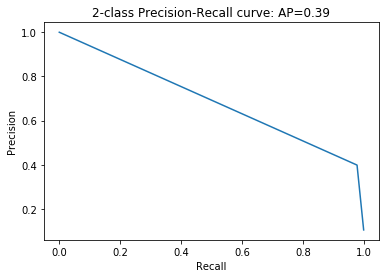

In [104]:
plot_pr_curve(random_forest_max9, x_test, y_test)

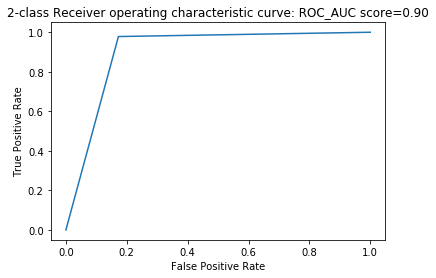

In [105]:
plot_roc_curve(random_forest_max9, x_test, y_test)

### EasyEnsembleClassifier

In [109]:
eec_400 = EasyEnsembleClassifier(n_estimators=400, random_state=17, n_jobs=4)
eec_wrapper = Sklearn_Model_Wrapper(eec_400)

In [ ]:
eec_wrapper.fit(x_train, y_train)
evaluate_model(eec_wrapper, x_test, y_test, verbose=True, model_name="easyEnsemble_classifier_400")

In [ ]:
plot_pr_curve(eec_wrapper, x_test, y_test)

In [ ]:
plot_roc_curve(eec_wrapper, x_test, y_test)

### Model results
We write the scores on the test set of the other models we tried to the elegans_results_test.csv file. Please note that these models were not evaluated on the test set prior to this point. 

In [ ]:
svm = Sklearn_Model_Wrapper(LinearSVC(random_state=0, tol=1e-5, max_iter=5000, class_weight=class_weight))

cross_validation(svm, x_train, y_train)

In [ ]:
rusboost = RUSBoostClassifier(n_estimators=200, algorithm='SAMME.R',random_state=17)
random_forest_max8 = Sklearn_Model_Wrapper(rusboost)
cross_validation(random_forest_max8, x_train, y_train)

In [ ]:
fully_connected_model_wrapper = Keras_Model_Wrapper(get_fully_connected_model(), class_weights=class_weight_01, epochs=10)
cross_validation(fully_connected_model_wrapper, x_train, y_train, folds=5)

In [ ]:
for solver in solvers:
    logistic_regression = LogisticRegression(random_state=13, max_iter=10000, class_weight=class_weight, solver=solver)
    logistic_regression_wrapper = Sklearn_Model_Wrapper(logistic_regression)
    cross_validation(logistic_regression_wrapper, x_train, y_train, message='solver={0}'.format(solver))

## Conclusions

In order to accurately predicting Splice site in C. Elegans DNA strings we have done experiments with multiple different approaches. Our main challenge was the small size of the dataset in combination with its vast class imbalance.  
On all models, class weights turned out to be the most important parameter to overcome this imbalance. Our best results hovever were achieved using the [imbalanced-learn](https://imbalanced-learn.readthedocs.io/en/stable/) library using bagging and boosting to reduce the imbalance.  
However for a real life application we would decide for the transfer learning approach. 